# Download Data

In this notebook, we will be using the [Robust Human Detection Data](https://link.springer.com/chapter/10.1007/978-981-15-7031-5_103).
Karthika, N. J., & Chandran, S. (2020). Addressing the False Positives in Pedestrian Detection. In Electronic Systems and Intelligent Computing (pp. 1083-1092). Springer, Singapore.

In [3]:
!aws s3 cp s3://deeplens-test-public/humandetection_data.zip .
!aws s3 cp s3://deeplens-test-public/pedestrian_safety_detection.zip .
    
!rm -rf humandetection/
!rm -rf humandetection_iot/

!unzip humandetection_data.zip -d humandetection
!unzip pedestrian_safety_detection.zip -d humandetection_iot

download: s3://deeplens-test-public/humandetection_data.zip to ./humandetection_data.zip
download: s3://deeplens-test-public/pedestrian_safety_detection.zip to ./pedestrian_safety_detection.zip
Archive:  humandetection_data.zip
   creating: humandetection/.ipynb_checkpoints/
   creating: humandetection/annotations/
   creating: humandetection/images/
   creating: humandetection/test_images/
  inflating: humandetection/val_mask.lst  
  inflating: humandetection/train_mask.idx  
  inflating: humandetection/train_mask.lst  
  inflating: humandetection/val_mask.rec  
  inflating: humandetection/train_mask.rec  
  inflating: humandetection/val_mask.idx  
  inflating: humandetection/annotations/Val_image (118).xml  
  inflating: humandetection/annotations/Train_image (682).xml  
  inflating: humandetection/annotations/Train_image (664).xml  
  inflating: humandetection/annotations/Train_image (442).xml  
  inflating: humandetection/annotations/Test_image (179).xml  
  inflating: humandetecti

In [4]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import lxml
import matplotlib.pyplot as plt
import os
import random
import cv2
random.seed(21)


In [5]:
DATA_IMG_PATH = './humandetection/images/'
DATA_ANN_PATH = './humandetection/annotations/'
DATA_PATH = './humandetection/'
FINAL_IMG_PATH = 'images/'

In [6]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [7]:
def generate_label(obj):
#     return obj.find('name').text
    if obj.find('name').text == "person":
        return 1
    elif obj.find('name').text == "person-like":
        return 0
    return 2

In [8]:
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'lxml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        
        return boxes, labels

In [9]:
imgs = list(sorted(os.listdir(DATA_IMG_PATH)))

In [10]:
df = pd.DataFrame(columns=['set','hsize','lsize','w','h','class','x1','y1','x2','y2','src'])
for img_name in imgs:
    img_id = (img_name.split('/')[-1]).split('.')[0]
    img_path = FINAL_IMG_PATH + img_name
    img = cv2.imread(DATA_IMG_PATH + img_name)
    h,w,_ = img.shape
    boxes, labels = generate_target(img_id,DATA_ANN_PATH+'{}.xml'.format(img_id))
    splitset = 'TRAIN'
    rn = random.random()
    if rn > 0.7 and rn < 0.9:
        splitset = 'VALIDATE'
    elif rn >= 0.9:
        splitset = 'TEST'
        
    for i,box in enumerate(boxes):
        df = df.append({
            'set':splitset,
            'hsize': 4,
            'lsize': 5,
            'w': w,
            'h': h,
            'class': labels[i],
            'x1': box[0]/w,
            'y1': box[1]/h,
            'x2': min(box[2],w)/w,
            'y2': min(box[3],h)/h,
            'src': img_path
        }, ignore_index=True)

In [11]:
df['class'].value_counts()

1    1626
0    1368
Name: class, dtype: int64

In [12]:
train_df = df[df['set'] == 'TRAIN']
val_df = df[df['set'] == 'VALIDATE']
n_train_samples = len(train_df)
n_val_samples = len(val_df)
print(n_train_samples, n_val_samples)

2024 611


In [13]:
del train_df['set']
train_df.to_csv(DATA_PATH + 'train_mask.lst', sep='\t', 
          header=False, index=True)

In [14]:
del val_df['set']
val_df.to_csv(DATA_PATH + 'val_mask.lst', sep='\t', 
          header=False, index=True)

In [15]:
import mxnet as mx
mxnet_path = mx.__file__[ : mx.__file__.rfind('/')]
print(mxnet_path)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet


In [16]:
!python $mxnet_path/tools/im2rec.py --pass-through --pack-label $DATA_PATH/train_mask.lst $DATA_PATH/

Creating .rec file from /home/ec2-user/SageMaker/humandetection/train_mask.lst in /home/ec2-user/SageMaker/humandetection
multiprocessing not available, fall back to single threaded encoding
time: 0.0009083747863769531  count: 0
time: 0.23420023918151855  count: 1000
time: 0.36174440383911133  count: 2000


In [17]:
!python $mxnet_path/tools/im2rec.py --pass-through --pack-label $DATA_PATH/val_mask.lst $DATA_PATH/

Creating .rec file from /home/ec2-user/SageMaker/humandetection/val_mask.lst in /home/ec2-user/SageMaker/humandetection
multiprocessing not available, fall back to single threaded encoding
time: 0.0006139278411865234  count: 0


# Train Model

In [18]:
BUCKET = 'deeplens-test-public'
PREFIX = 'deeplens-humandetection2class'

In [19]:
s3_output_location = 's3://{}/{}/output'.format(BUCKET, PREFIX)

In [20]:
s3train_rec = 's3://{}/{}/data/train.rec'.format(BUCKET, PREFIX)
s3val_rec = 's3://{}/{}/data/val.rec'.format(BUCKET, PREFIX)

!aws s3 cp humandetection/train_mask.rec $s3train_rec
!aws s3 cp humandetection/val_mask.rec $s3val_rec

upload: humandetection/train_mask.rec to s3://deeplens-test-public/deeplens-humandetection2class/data/train.rec
upload: humandetection/val_mask.rec to s3://deeplens-test-public/deeplens-humandetection2class/data/val.rec


In [21]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::418262057251:role/service-role/AmazonSageMaker-ExecutionRole-20200925T102744
CPU times: user 313 ms, sys: 32.4 ms, total: 345 ms
Wall time: 1 s


In [22]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `10` epochs. Based on our tests, train the model for `30` epochs with similar settings should give us reasonable detection results on the Pascal VOC data.

In [23]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=2,
                             mini_batch_size=32,
                             epochs=100,
                             learning_rate=0.003,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             num_training_samples=n_train_samples)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [24]:
train_data = sagemaker.session.s3_input(s3train_rec, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3val_rec, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [25]:
od_model.fit(inputs=data_channels, logs=True)

2021-01-14 19:16:35 Starting - Starting the training job...
2021-01-14 19:16:59 Starting - Launching requested ML instancesProfilerReport-1610651795: InProgress
......
2021-01-14 19:18:00 Starting - Preparing the instances for training............
2021-01-14 19:20:05 Downloading - Downloading input data
2021-01-14 19:20:05 Training - Downloading the training image...............
2021-01-14 19:22:25 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[01/14/2021 19:22:30 INFO 140028921575232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': 

## Testing model in the cloud
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [57]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

-------------------!

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us download an image from [PEXELS](https://www.pexels.com/) which the algorithm has so-far not seen. 

Let us use our endpoint to try to detect objects within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

The results are in a format that is similar to the .lst format with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [161]:
def inRestrictedSection(ImShape = None, R1 = None, restricted_region = None, kclass = None, score = None, threshold = None):
    statement = 'Person Not Detected in Restricted Zone'
    if (kclass == 1) and (score > threshold):
        Im1 = np.zeros((ImShape[0],ImShape[1],3), np.int32)
        cv2.fillPoly(Im1, [R1], 255)
        Im2 = np.zeros((ImShape[0],ImShape[1],3), np.int32)
        if restricted_region is None:
            restricted_region = np.array([[0,ImShape[0]],[ImShape[1],ImShape[0]],[ImShape[1],0], [0,0]], np.int32)
        cv2.fillPoly(Im2, [restricted_region], 255)
        Im = Im1 * Im2
        if np.sum(np.greater(Im, 0))>0:
            statement = 'Person Detected in Restricted Zone'
    else:
        statement = statement
    
    return statement

For the sake of this notebook, we trained the model with only a few (10) epochs. This implies that the results might not be optimal. To achieve better detection results, you can try to tune the hyperparameters and train the model for more epochs. In our tests, the mAP can reach 0.79 on the Pascal VOC dataset after training the algorithm with `learning_rate=0.0005`, `image_shape=512` and `mini_batch_size=16` for 240 epochs.

Person Not Detected in Restricted Zone


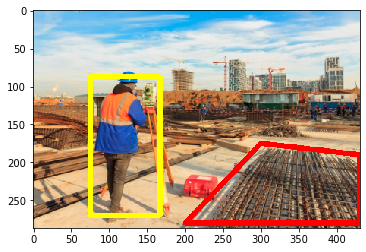

In [165]:
file_name = 'humandetection/test_images/test_2_image.png'
img = cv2.imread(file_name)
img =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
thresh = 0.1
height = img.shape[0]
width = img.shape[1]
colors = dict()

restricted_region = np.array([[200,280],[300,175],[430,190], [430,280]], np.int32)


with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)
    

results = object_detector.predict(b, initial_args={'ContentType': 'image/jpeg'})
detections = json.loads(results)

object_categories = ['no-person', 'person']

for det in detections['prediction']:
    (klass, score, x0, y0, x1, y1) = det
    if score < thresh:
        continue
    cls_id = int(klass)
    prob = score
    if cls_id not in colors:
        colors[cls_id] = (random.random(), random.random(), random.random())
    xmin = int(x0 * width)
    ymin = int(y0 * height)
    xmax = int(x1 * width)
    ymax = int(y1 * height)
    
    if cls_id==1: 
        R1 = np.array([[xmin,ymin],[xmax,ymin],[xmax,ymax], [xmin,ymax]], np.int32)
        cv2.polylines(img,[R1],True, (255,255,0), thickness = 5)
        cv2.polylines(img,[restricted_region],True, (255,0,0), thickness = 5)
        plt.imshow(img)
        print(inRestrictedSection(img.shape,R1 = R1, restricted_region= restricted_region, kclass = cls_id, score = prob, threshold=thresh))




Person Detected in Restricted Zone


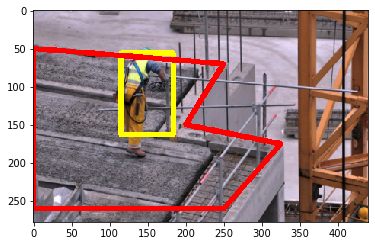

In [164]:
file_name = 'humandetection/test_images/test_3_image.png'
img = cv2.imread(file_name)
img =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
thresh = 0.06
height = img.shape[0]
width = img.shape[1]
colors = dict()

restricted_region = np.array([[0,260],[0,50],[250,70], [200,150], [325,175], [250,260]], np.int32)


with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)
    

results = object_detector.predict(b, initial_args={'ContentType': 'image/jpeg'})
detections = json.loads(results)

object_categories = ['no-person', 'person']

for det in detections['prediction']:
    (klass, score, x0, y0, x1, y1) = det
    if score < thresh:
        continue
    cls_id = int(klass)
    prob = score
    if cls_id not in colors:
        colors[cls_id] = (random.random(), random.random(), random.random())
    xmin = int(x0 * width)
    ymin = int(y0 * height)
    xmax = int(x1 * width)
    ymax = int(y1 * height)
    
    if cls_id==1: 
        R1 = np.array([[xmin,ymin],[xmax,ymin],[xmax,ymax], [xmin,ymax]], np.int32)
        cv2.polylines(img,[R1],True, (255,255,0), thickness = 5)
        cv2.polylines(img,[restricted_region],True, (255,0,0), thickness = 5)
        plt.imshow(img)
        print(inRestrictedSection(img.shape,R1 = R1, restricted_region= restricted_region, kclass = cls_id, score = prob, threshold=thresh))




Pedestrian Detected in Restricted Zone


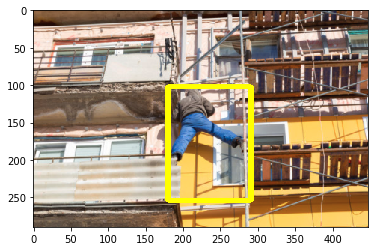

In [126]:
file_name = 'humandetection/test_images/test_1_image.png'
img = cv2.imread(file_name)
img =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
thresh = 0.1
height = img.shape[0]
width = img.shape[1]
colors = dict()

restricted_region = None


with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)
    

results = object_detector.predict(b, initial_args={'ContentType': 'image/jpeg'})
detections = json.loads(results)

object_categories = ['no-person', 'person']

for det in detections['prediction']:
    (klass, score, x0, y0, x1, y1) = det
    if score < thresh:
        continue
    cls_id = int(klass)
    prob = score
    if cls_id not in colors:
        colors[cls_id] = (random.random(), random.random(), random.random())
    xmin = int(x0 * width)
    ymin = int(y0 * height)
    xmax = int(x1 * width)
    ymax = int(y1 * height)
    
    if cls_id==1: 
        R1 = np.array([[xmin,ymin],[xmax,ymin],[xmax,ymax], [xmin,ymax]], np.int32)
        cv2.polylines(img,[R1],True, (255,255,0), thickness = 5)
        cv2.polylines(img,[restricted_region],True, (255,0,0), thickness = 5)
        plt.imshow(img)
        print(inRestrictedSection(img.shape,R1 = R1, restricted_region= restricted_region, kclass = cls_id, score = prob, threshold=thresh))




## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [53]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Convert model to deploy to DeepLens

In [54]:
!rm -rf incubator-mxnet
!git clone -b v1.7.x https://github.com/apache/incubator-mxnet

Cloning into 'incubator-mxnet'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 125636 (delta 2), reused 7 (delta 0), pack-reused 125621
Receiving objects: 100% (125636/125636), 87.11 MiB | 25.87 MiB/s, done.
Resolving deltas: 100% (87717/87717), done.


In [55]:
MODEL_PATH = od_model.model_data
TARGET_PATH ='s3://'+BUCKET+'/'+PREFIX+'/patched/'
!rm -rf tmp && mkdir tmp

In [56]:
!rm -rf tmp && mkdir tmp
!aws s3 cp $MODEL_PATH tmp
!tar -xzvf tmp/model.tar.gz -C tmp
!mv tmp/model_algo_1-0000.params tmp/ssd_resnet50_300-0000.params
!mv tmp/model_algo_1-symbol.json tmp/ssd_resnet50_300-symbol.json
!python incubator-mxnet/example/ssd/deploy.py --network resnet50 --data-shape 300 --num-class 2 --prefix tmp/ssd_
!tar -cvzf ./patched_model.tar.gz -C tmp ./deploy_ssd_resnet50_300-0000.params ./deploy_ssd_resnet50_300-symbol.json ./hyperparams.json
!aws s3 cp patched_model.tar.gz $TARGET_PATH

download: s3://deeplens-test-public/deeplens-humandetection2class/output/object-detection-2021-01-14-19-16-35-563/output/model.tar.gz to tmp/model.tar.gz
model_algo_1-0000.params
model_algo_1-symbol.json
hyperparams.json
[23:40:56] src/nnvm/legacy_json_util.cc:209: Loading symbol saved by previous version v1.4.1. Attempting to upgrade...
[23:40:56] src/nnvm/legacy_json_util.cc:217: Symbol successfully upgraded!
Saved model: tmp/deploy_ssd_resnet50_300-0000.params
Saved symbol: tmp/deploy_ssd_resnet50_300-symbol.json
./deploy_ssd_resnet50_300-0000.params
./deploy_ssd_resnet50_300-symbol.json
./hyperparams.json
upload: ./patched_model.tar.gz to s3://deeplens-test-public/deeplens-humandetection2class/patched/patched_model.tar.gz
